In [388]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import jax.numpy as jnp
from jax import grad , vmap
from matplotlib.colors import LogNorm
from ipywidgets import interact, IntSlider
from jax.scipy.spatial.transform import Rotation as R

In [389]:
def _calculate_rho(x, y, z, e, p, q, rho0, s, a, b):
    r = ((jnp.abs(x)**(2 - e) + (jnp.abs(y) / p)**(2 - e) + (jnp.abs(z) / q)**(2 - e)))**(1 / (2 - e))
    den = rho0 / ((r / s)**a * (1 + (r / s))**(b - a))
    return den/(p*q)

def rho(x, y, z, e, p, q, rho0, s, a, b):
    # Convert inputs to arrays
    x = jnp.asarray(x)
    y = jnp.asarray(y)
    z = jnp.asarray(z)

    # Check if inputs are arrays or scalars
    if x.ndim == 0:  # Scalar input
        return _calculate_rho(x, y, z, e, p, q, rho0, s, a, b)
    else:  # Array input
        # Check if inputs have the same length
        if x.size != y.size or x.size != z.size or y.size != z.size:
            raise ValueError("Input arrays must have the same length!")
        
        # Check if the length of inputs is reshapeable into a cube
        cube_len = int(round(x.size ** (1/3)))
        if cube_len ** 3 != x.size:
            raise ValueError("The length of the inputs must be reshapeable into a cube!")

        return _calculate_rho(x, y, z, e, p, q, rho0, s, a, b).reshape((cube_len, cube_len, cube_len))

In [390]:
def _calculate_gradient_rho(x, y, z, e, p, q, rho0, s, a, b, arg_num):
    grad_rho = grad(rho, argnums=arg_num)
    return grad_rho(x, y, z, e, p, q, rho0, s, a, b)

def gradient_rho(x, y, z, e, p, q, rho0, s, a, b, arg_num):
    # Convert inputs to arrays
    x = np.asarray(x)
    y = np.asarray(y)
    z = np.asarray(z)
    
    if not arg_num:
        raise ValueError("arg_num cannot be empty. Specify the arguments to differentiate with respect to.")
    
    # Check if inputs are arrays or scalars
    if x.ndim == 0:  # Scalar input
        return _calculate_gradient_rho(x, y, z, e, p, q, rho0, s, a, b, arg_num)
    else:  # Array input
        # Check if inputs have the same length
        if x.size != y.size or x.size != z.size or y.size != z.size:
            raise ValueError("Input arrays must have the same length!")
        
        # Define the function to compute the gradient
        grad_rho = grad(rho, argnums=arg_num)

        # Vectorize the gradient function
        vmap_grad_rho = vmap(lambda x, y, z: grad_rho(x, y, z, e, p, q, rho0, s, a, b), in_axes=(0, 0, 0))

        # Compute the gradients
        gradients = vmap_grad_rho(x, y, z)

        # Reshape and stack the gradients
        cube_len = int(round(x.size ** (1/3)))
        reshaped_gradients = [jnp.reshape(g, (cube_len, cube_len, cube_len)) for g in gradients]

        # Stack gradients along the last axis
        stacked_gradients = jnp.stack(reshaped_gradients, axis=-1)
        
        return stacked_gradients

In [391]:
def rotation(x,y,z,angle,axis):

    x = jnp.asarray(x)
    y = jnp.asarray(y)
    z = jnp.asarray(z)

    if(x.size!= y.size or x.size!= z.size or y.size!= z.size):
        raise ValueError("Input must have the same length!")

    if axis not in ['x', 'y', 'z']:
        raise ValueError("axis has to be either x , y or z!")
    
    rotation = R.from_euler(axis, angle, degrees=True)

    coordinates = jnp.array([x, y, z]).T
    
    rotated_coordinates = rotation.apply(coordinates)

    res = rotated_coordinates.T
    
    x_rot, y_rot, z_rot = res[0], res[1], res[2]

    return x_rot, y_rot, z_rot

    

In [392]:
'''def plot_img(proj_density_mat, extent, title = '' ):
    plt.imshow(proj_density_mat.T, origin= 'lower', extent=extent)
    plt.colorbar(label='Color Scale')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.show()'''


def plot_img(proj_density_mat, extent, title = '' ):
    plt.imshow(proj_density_mat.T, origin= 'lower', extent=extent)
    cbar = plt.colorbar(label='Color Scale')
    #cbar.set_ticks([np.min(proj_density_mat), np.max(proj_density_mat)])

    # Optionally, set tick labels to the min and max of your data
    #cbar.set_ticklabels([np.min(proj_density_mat), np.max(proj_density_mat)])

    min_val = np.min(proj_density_mat)
    max_val = np.max(proj_density_mat   )
    num_ticks = 5  # Number of ticks between min and max
    ticks = np.linspace(min_val, max_val, num_ticks + 2)[1:-1]  # Exclude min and max
    cbar.set_ticks(ticks)

    # Optionally, set tick labels to match the ticks
    cbar.set_ticklabels(["{:.8f}".format(tick) for tick in ticks])



    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.show()

In [393]:
s = 1. 
e = 0.2
p = 0.8
q = 1.
a = 2.
b = 4.
rho0 = 1.


# Define the size of your 3D matrix
x_size, y_size, z_size = 400, 400, 400
ex = 50

# Create 3D coordinates
x, y, z = np.meshgrid(np.linspace(-ex, ex, x_size),
                      np.linspace(-ex, ex, y_size),
                      np.linspace(-ex, ex, z_size), indexing = 'ij')
x = x.flatten()
y = y.flatten()
z = z.flatten()

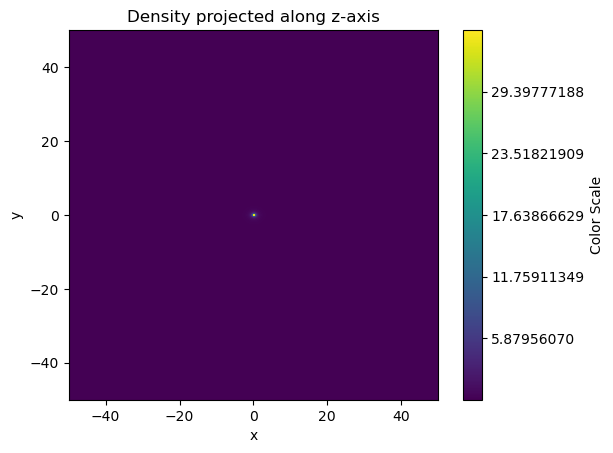

In [394]:
density = rho(x,y,z,e,p,q,rho0,s,a,b)

density = np.sum(density, axis = 2)
extent = [-ex, ex,-ex, ex]
plot_img(density, extent, 'Density projected along z-axis')

In [395]:
np.min(density)

Array(7.902056e-06, dtype=float32)

In [396]:
np.max(density)

Array(35.277325, dtype=float32)

In [397]:
density1 = rho(x[0],y[0],z[0],e,p,q,rho0,s,a,b)
density1

Array(1.21600765e-08, dtype=float32)

In [398]:
list_args = [0,1,2,3,4,5]
gradient_01 = gradient_rho(x,y,z,e,p,q,rho0,s,a,b,list_args)

In [399]:
gradx = gradient_01[:,:,:,0]
gradx = np.sum(gradx, axis=2)
grady = gradient_01[:,:,:,1]
grady = np.sum(grady, axis=2)
gradz = gradient_01[:,:,:,2]
gradz = np.sum(gradz, axis=2)
grade = gradient_01[:,:,:,3]
grade = np.sum(grade, axis=2)
gradp = gradient_01[:,:,:,4]
gradp = np.sum(gradp, axis=2)
gradq = gradient_01[:,:,:,5]
gradq = np.sum(gradq, axis=2)

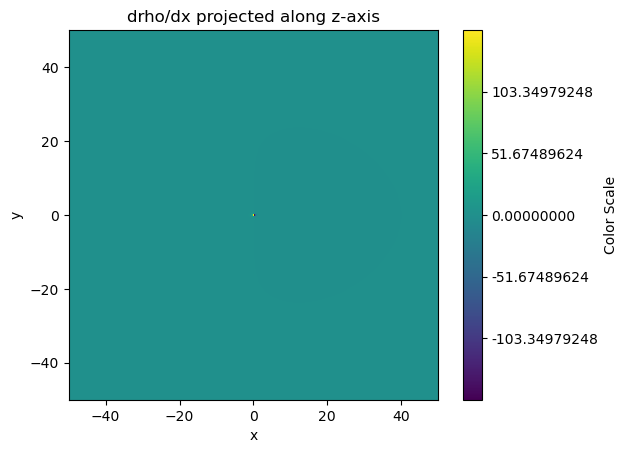

In [400]:
plot_img(gradx,extent, 'drho/dx projected along z-axis')

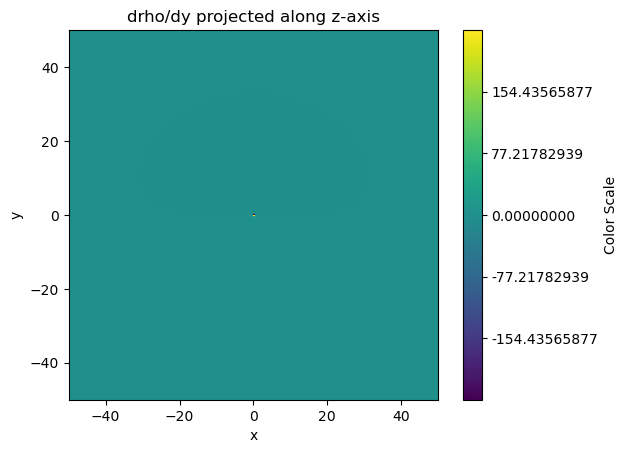

In [401]:
plot_img(grady,extent, 'drho/dy projected along z-axis')

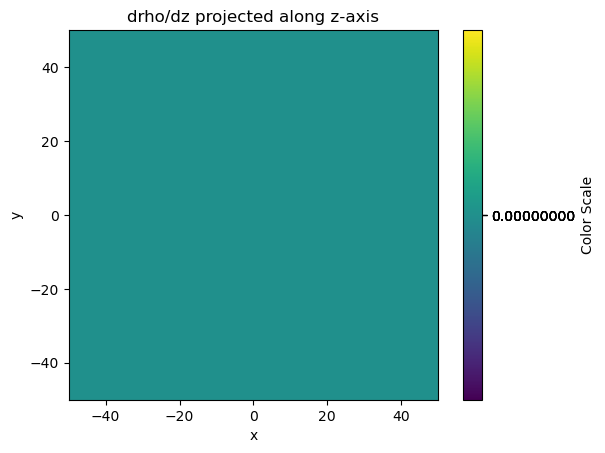

In [402]:
plot_img(gradz,extent, 'drho/dz projected along z-axis')

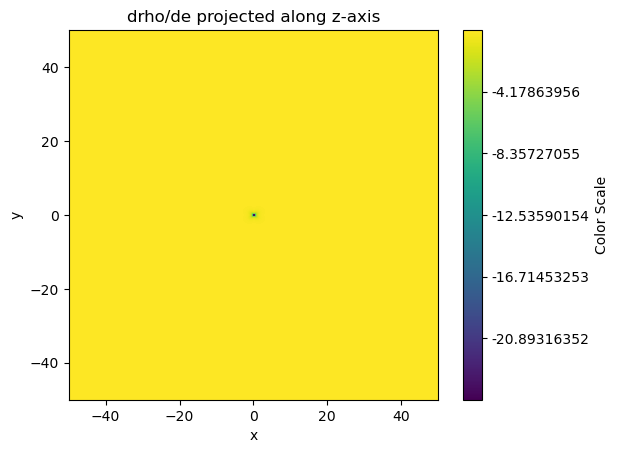

In [403]:
plot_img(grade,extent, 'drho/de projected along z-axis')
# Only works while using abs on x,y,z

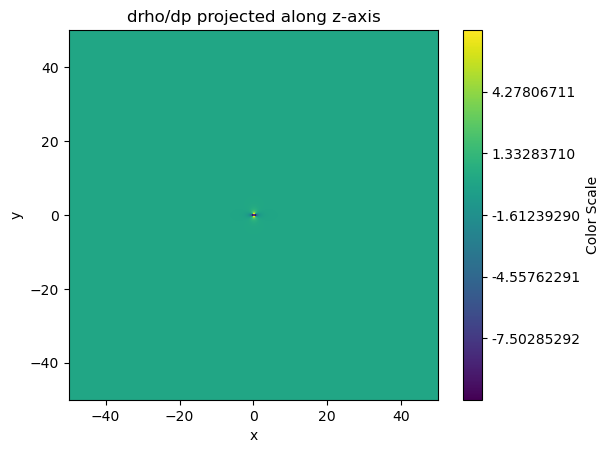

In [404]:
plot_img(gradp,extent, 'drho/dp projected along z-axis')

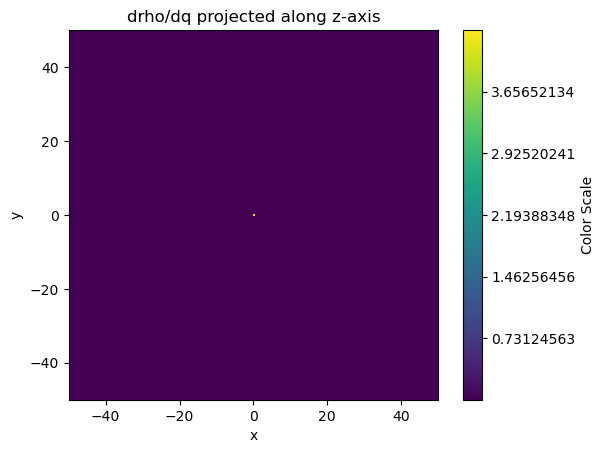

In [405]:
plot_img(gradq,extent, 'drho/dq projected along z-axis')

In [406]:
np.min(gradq)

Array(-7.330254e-05, dtype=float32)

In [407]:
np.max(gradq)

Array(4.3878403, dtype=float32)

In [408]:
np.mean(gradq)

Array(9.01559e-05, dtype=float32)

In [409]:
gradq

Array([[-4.8501652e-06, -4.8916659e-06, -4.9335144e-06, ...,
        -4.9335144e-06, -4.8916659e-06, -4.8501652e-06],
       [-4.8778811e-06, -4.9197270e-06, -4.9619248e-06, ...,
        -4.9619248e-06, -4.9197270e-06, -4.8778811e-06],
       [-4.9057148e-06, -4.9479077e-06, -4.9904565e-06, ...,
        -4.9904565e-06, -4.9479077e-06, -4.9057148e-06],
       ...,
       [-4.9057148e-06, -4.9479077e-06, -4.9904565e-06, ...,
        -4.9904565e-06, -4.9479077e-06, -4.9057148e-06],
       [-4.8778811e-06, -4.9197270e-06, -4.9619248e-06, ...,
        -4.9619248e-06, -4.9197270e-06, -4.8778811e-06],
       [-4.8501652e-06, -4.8916659e-06, -4.9335144e-06, ...,
        -4.9335144e-06, -4.8916659e-06, -4.8501652e-06]], dtype=float32)

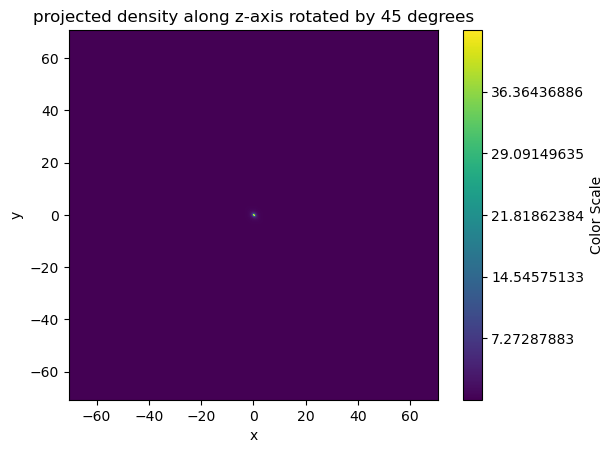

In [410]:
rot_x , rot_y , rot_z = rotation(x,y,z,45,'z')

rot_density = rho(rot_x,rot_y,rot_z,e,p,q,rho0,s,a,b)

rot_density = np.sum(rot_density, axis = 2)

extent = [np.min(rot_x),np.max(rot_x),np.min(rot_y),np.max(rot_y)]
plot_img(rot_density,extent, 'projected density along z-axis rotated by 45 degrees')

In [411]:
s = 1. 
e = 0.
p = 0.8
q = [0.1,0.3,0.5,0.7,1.]
a = 2.
b = 4.
rho0 = 1.
ex = [0.01,0.1,1,10,50]
Num = [10,50,100,200,400]

minis = []
maxis = []
means = []

for i in range(len(Num)):
    for j in range(len(ex)):
        for k in range(len(q)):
        # Define the size of your 3D matrix
            size = Num[i]
            ext = ex[j]

            # Create 3D coordinates
            x, y, z = np.meshgrid(np.linspace(-ext, ext, size),
                                np.linspace(-ext, ext, size),
                                np.linspace(-ext, ext, size), indexing = 'ij')
            x = x.flatten()
            y = y.flatten()
            z = z.flatten()


            list_args = [5]
            gradient_02 = gradient_rho(x,y,z,e,p,q[k],rho0,s,a,b,list_args)

            gradqq = gradient_02[:,:,:,0]
            gradqq = np.sum(gradqq, axis=2)

            mini = np.min(gradqq)
            maxi = np.max(gradqq)
            mean = np.mean(gradqq)

            minis.append(mini)
            maxis.append(maxi)
            means.append(mean)

            print("For N = "+str(size)+" , extent = "+str(-ext)+" - "+str(ext)+" , q = "+str(q[k])+" :")
            print("Minimum of the gradient q : "+str(mini))
            print("Maximum of the gradient q : "+str(maxi))
            print("Mean of the gradient q : "+str(mean)+"\n")

For N = 10 , extent = -0.01 - 0.01 , q = 0.1 :
Minimum of the gradient q : 24584.875
Maximum of the gradient q : 2243726.5
Mean of the gradient q : 664195.4

For N = 10 , extent = -0.01 - 0.01 , q = 0.3 :
Minimum of the gradient q : -85353.22
Maximum of the gradient q : 1383800.9
Mean of the gradient q : 9902.908

For N = 10 , extent = -0.01 - 0.01 , q = 0.5 :
Minimum of the gradient q : -87475.766
Maximum of the gradient q : 594544.5
Mean of the gradient q : -49238.484

For N = 10 , extent = -0.01 - 0.01 , q = 0.7 :
Minimum of the gradient q : -89093.61
Maximum of the gradient q : 181906.42
Mean of the gradient q : -59839.688

For N = 10 , extent = -0.01 - 0.01 , q = 1.0 :
Minimum of the gradient q : -88935.81
Maximum of the gradient q : -31732.973
Mean of the gradient q : -55585.184

For N = 10 , extent = -0.1 - 0.1 , q = 0.1 :
Minimum of the gradient q : 704.3528
Maximum of the gradient q : 21126.535
Mean of the gradient q : 6545.5103

For N = 10 , extent = -0.1 - 0.1 , q = 0.3 :
Mi

In [414]:
size = 400
ext = 50
q = 1.

# Create 3D coordinates
x, y, z = np.meshgrid(np.linspace(-ext, ext, size),
                    np.linspace(-ext, ext, size),
                    np.linspace(-ext, ext, size), indexing = 'ij')
x = x.flatten()
y = y.flatten()
z = z.flatten()


list_args = [5]
gradient_02 = gradient_rho(x,y,z,e,p,q,rho0,s,a,b,list_args)

gradqq = gradient_02[:,:,:,0]
gradqq = np.sum(gradqq, axis=2)

mini = np.min(gradqq)
maxi = np.max(gradqq)
mean = np.mean(gradqq)



print("For N = "+str(size)+" , extent = "+str(-ext)+" - "+str(ext)+" , q = "+str(q)+" :")
print("Minimum of the gradient q : "+str(mini))
print("Maximum of the gradient q : "+str(maxi))
print("Mean of the gradient q : "+str(mean)+"\n")

For N = 400 , extent = -50 - 50 , q = 1.0 :
Minimum of the gradient q : -7.610023e-05
Maximum of the gradient q : 4.3121934
Mean of the gradient q : 7.940214e-05



In [415]:
list_args = [5]
gradient_02 = gradient_rho(0,0,0,e,p,q,rho0,s,a,b,list_args)

In [416]:
gradient_02

(Array(nan, dtype=float32, weak_type=True),)